In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-01-13 16:04:30.373671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
dataset = pd.read_csv('../../data/energy_weather.csv', index_col=0)
# https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [4]:
data.columns

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')

### Preprocess

In [66]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (34980, 2184)


In [67]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 4
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 1872) (24486, 12) (5247, 1872) (5247, 12) (5247, 1872) (5247, 12)


In [68]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 72, 26) (24486, 12) (5247, 72, 26) (5247, 12) (5247, 72, 26) (5247, 12)


### PM threshold

In [69]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(24486,)
(5247,)
(5247,)


In [70]:
bin_nums = 20

# Step 1: Calculate the histogram
counts, bin_edges = np.histogram(train_X_pm, bins=bin_nums)

# Step 2: Invert counts to assign lower weights to more frequent bins, avoid division by zero by adding a small number (epsilon)
epsilon = 1e-8
weights = np.sqrt(1.0 / (counts + epsilon))
# weights = 1.0 / (counts + epsilon)

# Step 3: Normalize the weights (optional)
# weights /= np.max(weights)
weights /= np.sum(weights) * len(counts)

# Step 4: Assign weights to each sample based on the bin it falls into
sample_weights = np.zeros(train_X_pm.shape[0])

for i, value in enumerate(train_X_pm):
    
    # Find the index of the bin this sample falls into
    bin_index = np.digitize(value, bin_edges) - 1
    bin_index = min(bin_index, bin_nums - 1)
    
    # Assign the corresponding weight
    sample_weights[i] = weights[bin_index]

In [71]:
sample_weights.shape

(24486,)

In [72]:
# sample_weights /= np.sum(sample_weights)
sample_weights /= np.max(sample_weights)
# sample_weights = (sample_weights - sample_weights.min()) / (sample_weights.max()-sample_weights.min()) + 0.1

(array([21558.,  1669.,   464.,   328.,   288.,     0.,     0.,     0.,
          105.,     0.,     0.,     0.,     0.,    50.,     0.,     0.,
            0.,     0.,     0.,    24.]),
 array([0.10056729, 0.14553893, 0.19051056, 0.2354822 , 0.28045383,
        0.32542547, 0.3703971 , 0.41536874, 0.46034037, 0.50531201,
        0.55028365, 0.59525528, 0.64022692, 0.68519855, 0.73017019,
        0.77514182, 0.82011346, 0.86508509, 0.91005673, 0.95502836,
        1.        ]),
 <BarContainer object of 20 artists>)

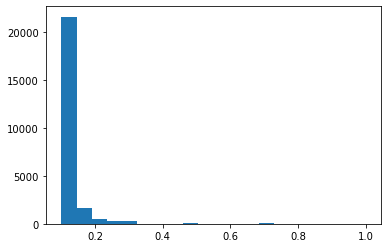

In [73]:
plt.hist(sample_weights, bins=20)

In [74]:
np.save('sample_weights_load_IPF.npy', sample_weights)

### Model

In [75]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [76]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [77]:
model.compile(optimizer='adam',
#               loss=custom_weight_loss,
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/load_all_weighted_IPF_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=sample_weights
         )

Epoch 1/1000
48/48 - 2s - loss: 0.0080 - mae: 0.2013 - val_loss: 0.0482 - val_mae: 0.1873

Epoch 00001: val_mae improved from inf to 0.18727, saving model to ../../saved_models/hydro_all_weighted_IPF_95.h5
Epoch 2/1000
48/48 - 1s - loss: 0.0040 - mae: 0.1472 - val_loss: 0.0274 - val_mae: 0.1319

Epoch 00002: val_mae improved from 0.18727 to 0.13186, saving model to ../../saved_models/hydro_all_weighted_IPF_95.h5
Epoch 3/1000
48/48 - 1s - loss: 0.0019 - mae: 0.0945 - val_loss: 0.0165 - val_mae: 0.0999

Epoch 00003: val_mae improved from 0.13186 to 0.09993, saving model to ../../saved_models/hydro_all_weighted_IPF_95.h5
Epoch 4/1000
48/48 - 1s - loss: 0.0015 - mae: 0.0826 - val_loss: 0.0143 - val_mae: 0.0920

Epoch 00004: val_mae improved from 0.09993 to 0.09199, saving model to ../../saved_models/hydro_all_weighted_IPF_95.h5
Epoch 5/1000
48/48 - 1s - loss: 0.0013 - mae: 0.0773 - val_loss: 0.0133 - val_mae: 0.0870

Epoch 00005: val_mae improved from 0.09199 to 0.08702, saving model to ..

48/48 - 1s - loss: 2.2478e-04 - mae: 0.0324 - val_loss: 0.0217 - val_mae: 0.1097

Epoch 00051: val_mae did not improve from 0.07477
Epoch 52/1000
48/48 - 1s - loss: 2.1026e-04 - mae: 0.0312 - val_loss: 0.0241 - val_mae: 0.1154

Epoch 00052: val_mae did not improve from 0.07477
Epoch 53/1000
48/48 - 1s - loss: 2.0910e-04 - mae: 0.0312 - val_loss: 0.0240 - val_mae: 0.1158

Epoch 00053: val_mae did not improve from 0.07477
Epoch 54/1000
48/48 - 1s - loss: 2.0697e-04 - mae: 0.0310 - val_loss: 0.0249 - val_mae: 0.1174

Epoch 00054: val_mae did not improve from 0.07477
Epoch 55/1000
48/48 - 1s - loss: 1.9914e-04 - mae: 0.0304 - val_loss: 0.0261 - val_mae: 0.1193

Epoch 00055: val_mae did not improve from 0.07477
Epoch 56/1000
48/48 - 1s - loss: 1.9662e-04 - mae: 0.0302 - val_loss: 0.0242 - val_mae: 0.1156

Epoch 00056: val_mae did not improve from 0.07477
Epoch 57/1000
48/48 - 1s - loss: 1.9117e-04 - mae: 0.0298 - val_loss: 0.0246 - val_mae: 0.1173

Epoch 00057: val_mae did not improve from 


Epoch 00107: val_mae did not improve from 0.07477
Epoch 108/1000
48/48 - 1s - loss: 7.9012e-05 - mae: 0.0189 - val_loss: 0.0304 - val_mae: 0.1318

Epoch 00108: val_mae did not improve from 0.07477
Epoch 109/1000
48/48 - 1s - loss: 8.7079e-05 - mae: 0.0199 - val_loss: 0.0313 - val_mae: 0.1337

Epoch 00109: val_mae did not improve from 0.07477
Epoch 110/1000
48/48 - 1s - loss: 8.7271e-05 - mae: 0.0200 - val_loss: 0.0313 - val_mae: 0.1337

Epoch 00110: val_mae did not improve from 0.07477
Epoch 111/1000
48/48 - 1s - loss: 8.3761e-05 - mae: 0.0195 - val_loss: 0.0297 - val_mae: 0.1305

Epoch 00111: val_mae did not improve from 0.07477
Epoch 112/1000
48/48 - 1s - loss: 9.9170e-05 - mae: 0.0215 - val_loss: 0.0309 - val_mae: 0.1331

Epoch 00112: val_mae did not improve from 0.07477
Epoch 113/1000
48/48 - 1s - loss: 8.3405e-05 - mae: 0.0195 - val_loss: 0.0310 - val_mae: 0.1334

Epoch 00113: val_mae did not improve from 0.07477
Epoch 114/1000
48/48 - 1s - loss: 7.9048e-05 - mae: 0.0190 - val_lo


Epoch 00163: val_mae did not improve from 0.07477
Epoch 164/1000
48/48 - 1s - loss: 5.6631e-05 - mae: 0.0159 - val_loss: 0.0315 - val_mae: 0.1341

Epoch 00164: val_mae did not improve from 0.07477
Epoch 165/1000
48/48 - 1s - loss: 5.4731e-05 - mae: 0.0156 - val_loss: 0.0318 - val_mae: 0.1350

Epoch 00165: val_mae did not improve from 0.07477
Epoch 166/1000
48/48 - 1s - loss: 6.7751e-05 - mae: 0.0176 - val_loss: 0.0316 - val_mae: 0.1348

Epoch 00166: val_mae did not improve from 0.07477
Epoch 167/1000
48/48 - 1s - loss: 5.5125e-05 - mae: 0.0157 - val_loss: 0.0317 - val_mae: 0.1350

Epoch 00167: val_mae did not improve from 0.07477
Epoch 168/1000
48/48 - 1s - loss: 6.3685e-05 - mae: 0.0170 - val_loss: 0.0331 - val_mae: 0.1373

Epoch 00168: val_mae did not improve from 0.07477
Epoch 169/1000
48/48 - 1s - loss: 5.5901e-05 - mae: 0.0158 - val_loss: 0.0306 - val_mae: 0.1323

Epoch 00169: val_mae did not improve from 0.07477
Epoch 170/1000
48/48 - 1s - loss: 8.1636e-05 - mae: 0.0195 - val_lo